In [12]:
%load_ext autoreload
from ddls.plotting.plotting import plot_line, plot_bar, plot_hist, PlotAesthetics

from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob
import os
import time
import pandas as pd
import numpy as np
import scipy.stats as st
import sigfig

import gzip
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
# set paths to agent(s)

base_folder = '/scratch/datasets/ddls/sims/'

# base_name = 'job_placing'
# # ids = [108]
# ids = [108, 116]

# base_name = 'ramp_job_placement_shaping'
base_name = 'ramp_job_partitioning'
agent_to_id = {
    
    # 'Random': 349,
    # 'First Fit': 350,
    # 'Last Fit': 351,
    # # 'RL': f'{base_folder}/{base_name}/{base_name}_{348}/checkpoints/checkpoint_000002/',
    # 'RL': 363,
    
    # AlexNet
    # 'First Fit': 381,
    # 'RL': f'{base_folder}/{base_name}/{base_name}_{385}/checkpoints/checkpoint_000006/',
    
    # # 5 'small' graphs (image classification and NMT) -> 1000 in an episode (replication_factor=200)
    # 'First Fit': 441,
    # # 'RL': f'{base_folder}/{base_name}/{base_name}_{437}/checkpoints/checkpoint_000002/',
    
    
    
    
    # RAMP_JOB_PARTITIONING
    
    # 200 AlexNet, max_partitions_per_op=None
    'Random': 64,
    'No\nParallelism': 78,
    'Max\nParallelism': 79,
    'SiP-ML': 67,
}

In [80]:
# load data

episode_metrics = {
    'num_jobs_arrived',
    'num_jobs_completed',
    'num_jobs_blocked',
}

episode_completion_metrics = {
    'job_completion_time',
    'job_communication_overhead_time',
    'job_computation_overhead_time',
    'jobs_completed_num_nodes',
    'jobs_completed_num_edges',
    'jobs_completed_total_operation_memory_cost',
    'jobs_completed_total_dependency_size',
}

episode_blocked_metrics = {
    'jobs_blocked_num_nodes',
    'jobs_blocked_num_edges',
    'jobs_blocked_total_operation_memory_cost',
    'jobs_blocked_total_dependency_size',
}

# 'jobs_blocked_causes', # TODO: Process strings properly below when plotting
step_metrics = set()

agent_to_episode_stats_dict = defaultdict(list)
agent_to_episode_completion_stats_dict = defaultdict(list)
agent_to_episode_blocked_stats_dict = defaultdict(list)

agent_to_step_stats_dict = defaultdict(list)

for agent, _id in agent_to_id.items():
    if isinstance(_id, int):
        # use int id to generate string dir to data
        agent_dir = base_folder + f'{base_name}/{base_name}_{_id}/'
    else:
        # string dir to data already provided
        agent_dir = _id
    if os.path.isdir(agent_dir):
        print(f'\nLoading validation data from {agent_dir[:-1]}...')
            
        completion_stats_found, blocked_stats_found = False, False

        # load episode stats
        with gzip.open(agent_dir+'episode_stats.pkl', 'rb') as f:
            episode_stats = pickle.load(f)
        for metric, result in episode_stats.items():
            if metric in episode_metrics:
                try:
                    agent_to_episode_stats_dict[metric].extend(result)
                except TypeError:
                    agent_to_episode_stats_dict[metric].append(result)
            elif metric in episode_completion_metrics:
                completion_stats_found = True
                try:
                    agent_to_episode_completion_stats_dict[metric].extend(result)
                except TypeError:
                    agent_to_episode_completion_stats_dict[metric].append(result)
            elif metric in episode_blocked_metrics:
                blocked_stats_found = True
                try:
                    agent_to_episode_blocked_stats_dict[metric].extend(result)
                except TypeError:
                    agent_to_episode_blocked_stats_dict[metric].append(result)
            else:
                raise Exception(f'Unrecognised metric {metric}')
        agent_to_episode_stats_dict['Agent'].append(agent)
        if completion_stats_found:
            agent_to_episode_completion_stats_dict['Agent'].append(agent)
        if blocked_stats_found:
            agent_to_episode_blocked_stats_dict['Agent'].append(agent)

        # load step stats
        with gzip.open(agent_dir+'step_stats.pkl', 'rb') as f:
            step_stats = pickle.load(f)
        for metric, result in step_stats.items():
            try:
                agent_to_step_stats_dict[metric].extend(result)
            except TypeError:
                agent_to_step_stats_dict[metric].append(result)
            step_metrics.add(metric)
        agent_to_step_stats_dict['Agent'].extend([agent for _ in range(len(result))])
        
        print(f'Checkpoints loaded from {agent_dir[:-1]}.')
    else:
        print(f'\nNo checkpoints/ folder found in {agent_dir[:-1]}')
       
print(f'\nEpisode stats:')
# print(agent_to_episode_stats_dict)
episode_stats_df = pd.DataFrame(agent_to_episode_stats_dict)
display(episode_stats_df)
# print(agent_to_episode_completion_stats_dict)
episode_completion_stats_df = pd.DataFrame(agent_to_episode_completion_stats_dict)
display(episode_completion_stats_df)
# print(agent_to_episode_blocked_stats_dict)
episode_blocked_stats_df = pd.DataFrame(agent_to_episode_blocked_stats_dict)
display(episode_blocked_stats_df)

print(f'\nStep stats:')
# print(agent_to_step_stats_dict)
# for key, val in agent_to_step_stats_dict.items():
#     print(f'{key} -> {len(val)} vals')
step_stats_df = pd.DataFrame(agent_to_step_stats_dict)
display(step_stats_df)


Loading validation data from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_64...
Checkpoints loaded from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_64.

Loading validation data from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_78...
Checkpoints loaded from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_78.

Loading validation data from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_79...
Checkpoints loaded from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_79.

Loading validation data from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_67...
Checkpoints loaded from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_67.

Episode stats:


,num_jobs_arrived,num_jobs_completed,num_jobs_blocked,Agent
0,200.0,68.0,132.0,Random
1,200.0,175.0,25.0,No\nParallelism
2,200.0,100.0,100.0,Max\nParallelism
3,200.0,160.0,40.0,SiP-ML


,job_completion_time,job_communication_overhead_time,job_computation_overhead_time,jobs_completed_num_nodes,jobs_completed_num_edges,jobs_completed_total_operation_memory_cost,jobs_completed_total_dependency_size,Agent
0,11427.445046,11427.445046,11399.341390,225.941176,3583.205882,3.046234e+09,9.830013e+09,Random
1,36061.150000,36061.150000,36061.150000,46.000000,47.000000,3.046234e+09,2.910968e+09,No\nParallelism
2,1708.970593,1708.970593,1563.489994,1224.000000,52964.000000,3.046234e+09,4.922835e+10,Max\nParallelism
3,4953.676762,4953.676762,4902.009758,312.000000,3260.000000,3.046234e+09,1.322718e+10,SiP-ML


,jobs_blocked_num_nodes,jobs_blocked_num_edges,jobs_blocked_total_operation_memory_cost,jobs_blocked_total_dependency_size,Agent
0,46.0,47.0,3.046234e+09,2.422161e+09,Random
1,46.0,47.0,3.046234e+09,2.422161e+09,No\nParallelism
2,46.0,47.0,3.046234e+09,2.422161e+09,Max\nParallelism
3,46.0,47.0,3.046234e+09,2.422161e+09,SiP-ML



Step stats:


,action,reward,step_counter,step_start_time,mean_num_mounted_workers,mean_num_mounted_channels,mean_compute_throughput,mean_comm_throughput,mean_cluster_throughput,mean_compute_overhead_frac,mean_comm_overhead_frac,mean_mounted_worker_utilisation_frac,mean_cluster_worker_utilisation_frac,num_jobs_completed,mean_num_jobs_running,num_jobs_arrived,num_jobs_blocked,step_end_time,job_queue_length,Agent
0,4,-0.129899,0,0.0,4.0,12.0,3.251542e+05,7.714066e+05,1.096561e+06,1.0,0.998376,0.962289,0.120286,0,1.0,1,0,1000.000000,1,Random
1,2,-0.253324,1,1000.0,6.0,14.0,4.918857e+05,1.002760e+06,1.494645e+06,1.0,0.999019,0.974584,0.182735,0,2.0,1,0,2000.000000,1,Random
2,1,-1.000000,2,2000.0,6.0,14.0,4.918857e+05,1.002760e+06,1.494645e+06,1.0,0.999019,0.974584,0.182735,0,2.0,1,1,3000.000000,1,Random
3,1,-1.000000,3,3000.0,6.0,14.0,4.918857e+05,1.002760e+06,1.494645e+06,1.0,0.999019,0.974584,0.182735,0,2.0,1,1,4000.000000,1,Random
4,1,-1.000000,4,4000.0,6.0,14.0,4.918857e+05,1.002760e+06,1.494645e+06,1.0,0.999019,0.974584,0.182735,0,2.0,1,1,5000.000000,1,Random
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,8,-0.068684,349,195000.0,28.0,196.0,2.152304e+06,9.345611e+06,1.149792e+07,1.0,0.989570,0.909959,0.796214,1,3.5,1,0,196000.000000,1,SiP-ML
796,8,-0.068684,351,196000.0,28.0,196.0,2.152304e+06,9.345611e+06,1.149792e+07,1.0,0.989570,0.909959,0.796214,1,3.5,1,0,197000.000000,1,SiP-ML
797,8,-0.068684,353,197000.0,28.0,196.0,2.152304e+06,9.345611e+06,1.149792e+07,1.0,0.989570,0.909959,0.796214,1,3.5,1,0,198000.000000,1,SiP-ML
798,8,-0.068684,354,198000.0,32.0,224.0,2.459777e+06,1.068070e+07,1.314048e+07,1.0,0.989570,0.909959,0.909959,0,4.0,1,0,199000.000000,1,SiP-ML


In [81]:
aesthetics = PlotAesthetics()
aesthetics.set_icml_paper_plot_aesthetics() # paper training curve

estimator = np.mean # np.mean np.median

scaling_factor = 1
width_scaling_factor = 1
height_scaling_factor = 1

step_stats_xaxis = 'step_end_time'
step_stats_xaxis_label = 'Time (s)'

legend = 'auto'

ylog = False
xlog = False

ci = None
errcolor = 'gray'
capsize = 0.05


# display bar chart values
display_values = True
# display_values = False
y_offset = 0
# loc = 'bottom'
loc = 'top'




def show_values_on_bars(axs, sigfigs=2, y_offset=0, loc='top'):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            if loc == 'top':
                _x = p.get_x() + p.get_width() / 2
    #             _y = p.get_y() + p.get_height()
    #             _y = p.get_y() + y_offset
                _y = p.get_height() + y_offset
                value = sigfig.round(p.get_height(), sigfigs=sigfigs)
                ax.text(_x, _y, value, ha="center") 
            elif loc == 'bottom':
                _x = p.get_x() + p.get_width() / 2
    #             _y = p.get_y() + p.get_height()
                _y = p.get_y() + y_offset
                value = sigfig.round(p.get_height(), sigfigs=sigfigs)
                ax.text(_x, _y, value, ha="center") 
            else:
                raise Exception(f'Unrecognised loc {loc}')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def barplot(df, metric, x='Agent', display_values=True):
    print(f'Plotting metric {metric} -> min={np.min(df[metric])} | max={np.max(df[metric])} | mean={np.mean(df[metric])}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.barplot(data=df,
                    x=x,
                    y=metric,
                    # order=order,
                    # palette=palette,
                    estimator=estimator,
                    ci=ci,
                    errcolor=errcolor,
                    capsize=capsize)
    g.set_xlabel('Agent')
    g.set_ylabel(metric)
    ax.tick_params(axis='both', which='major', pad=2)
    plt.xticks(fontsize=7.5)
    ax.xaxis.labelpad = 2
    # ax.xaxis.label.set_size(2)
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    if ylog:
        g.set(yscale='log')
    if xlog:
        g.set(xscale='log')
    if display_values:
        show_values_on_bars(ax, sigfigs=3, y_offset=y_offset, loc=loc)
    plt.gcf().patch.set_alpha(0.0)
    plt.show()
    
def lineplot(df, metric):
    print(f'Plotting metric {metric} -> min={np.min(df[metric])} | max={np.max(df[metric])} | mean={np.mean(df[metric])}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.lineplot(data=df, 
                     x=step_stats_xaxis, 
                     y=metric, 
                     hue='Agent', 
                     linewidth=aesthetics.linewidth, 
                     legend=legend)
    # g = sns.scatterplot(data=episode_stats_df, x=xaxis, y=metric, hue='Agent', linewidth=aesthetics.linewidth, legend=legend)
    plt.title(metric)
    ax.tick_params(axis='both', which='major', pad=2)
    ax.xaxis.labelpad = 2
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    plt.gcf().patch.set_alpha(0.0)
    plt.show()



EPISODE METRICS
Plotting metric num_jobs_blocked -> min=25.0 | max=132.0 | mean=74.25


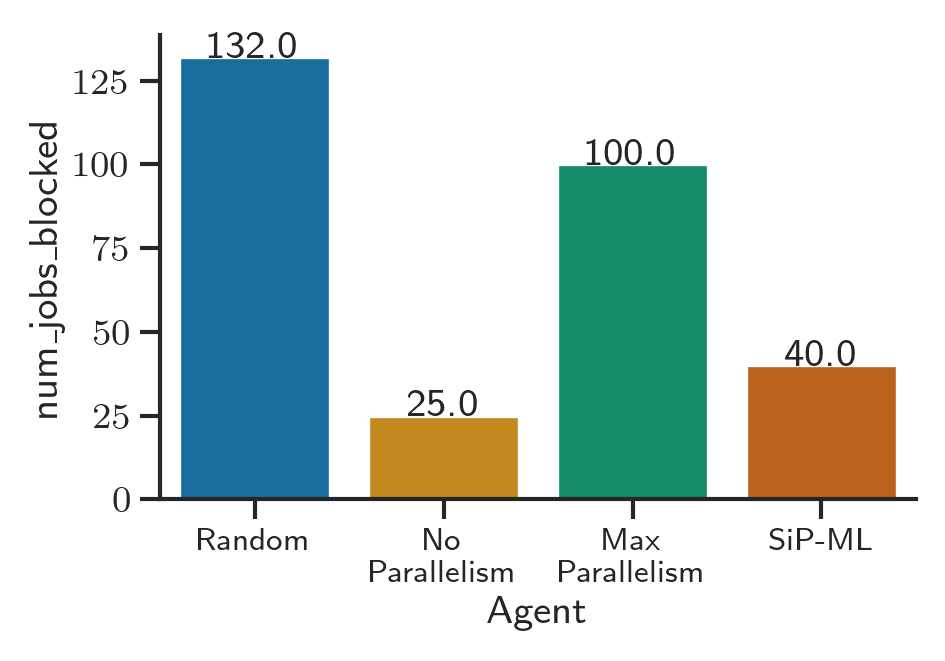

Plotting metric num_jobs_arrived -> min=200.0 | max=200.0 | mean=200.0


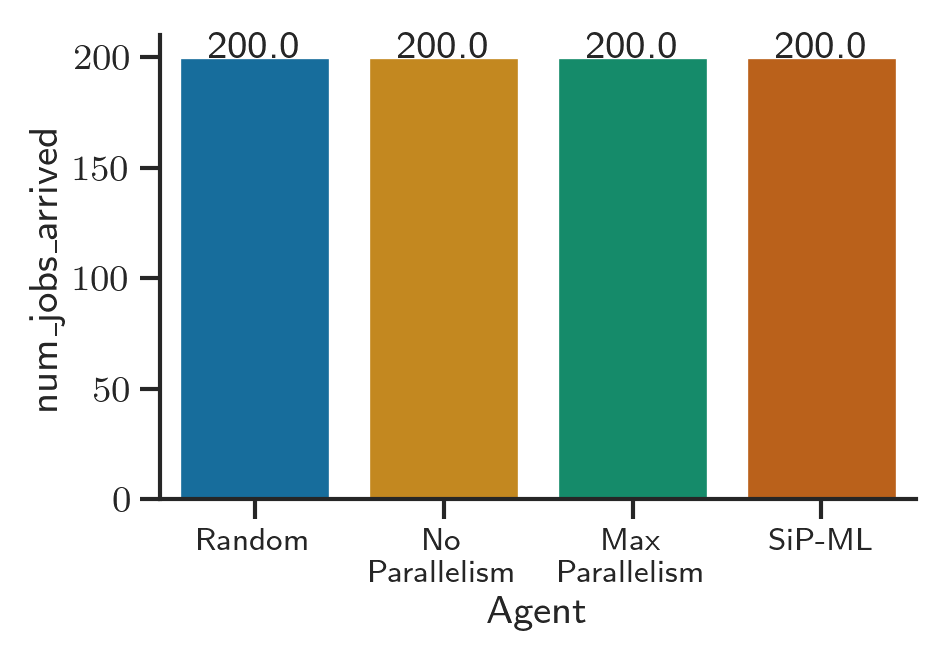

Plotting metric num_jobs_completed -> min=68.0 | max=175.0 | mean=125.75


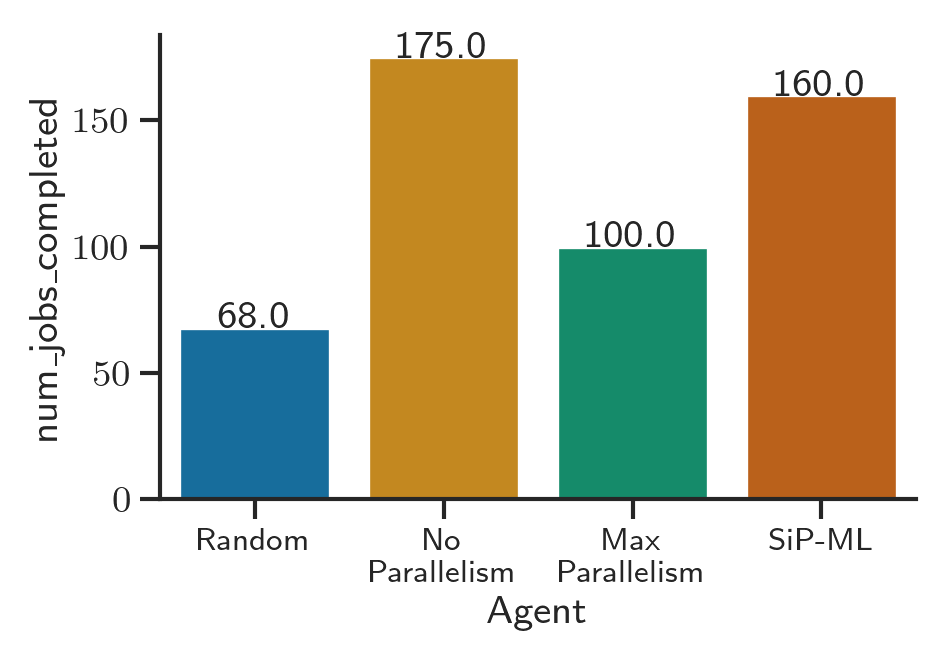

Plotting metric jobs_completed_num_edges -> min=47.0 | max=52964.0 | mean=14963.551470588236


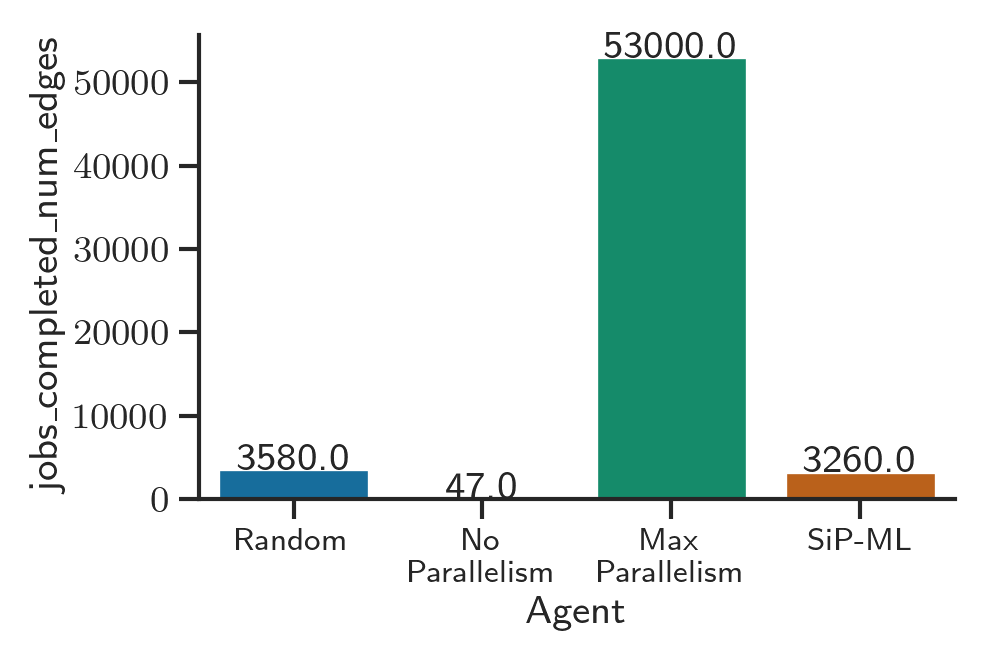

Plotting metric job_completion_time -> min=1708.9705933964003 | max=36061.15 | mean=13537.810600370489


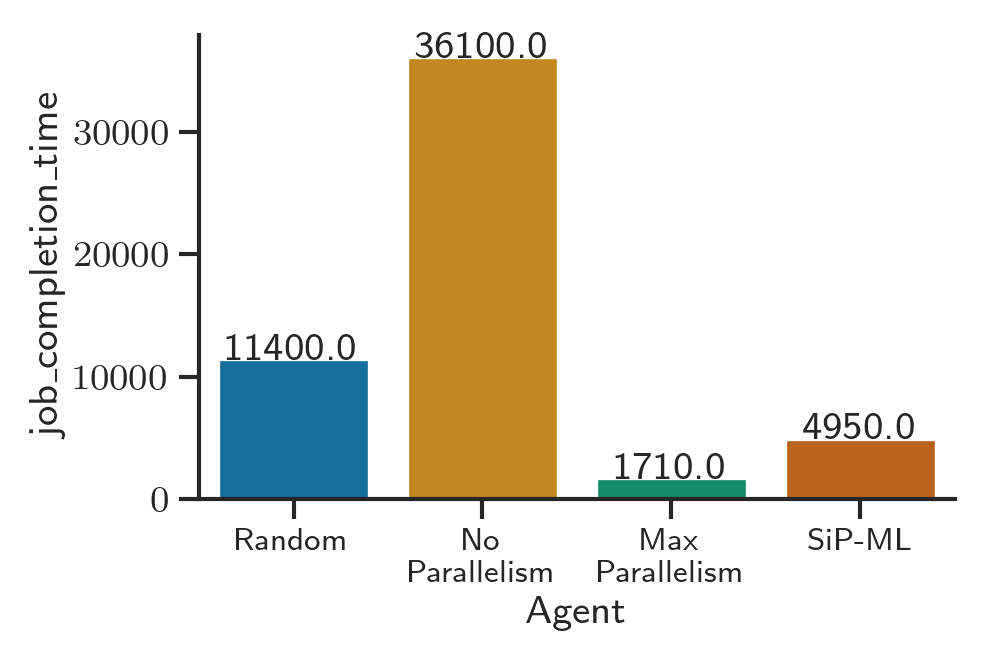

Plotting metric job_computation_overhead_time -> min=1563.4899939800023 | max=36061.15 | mean=13481.497785528114


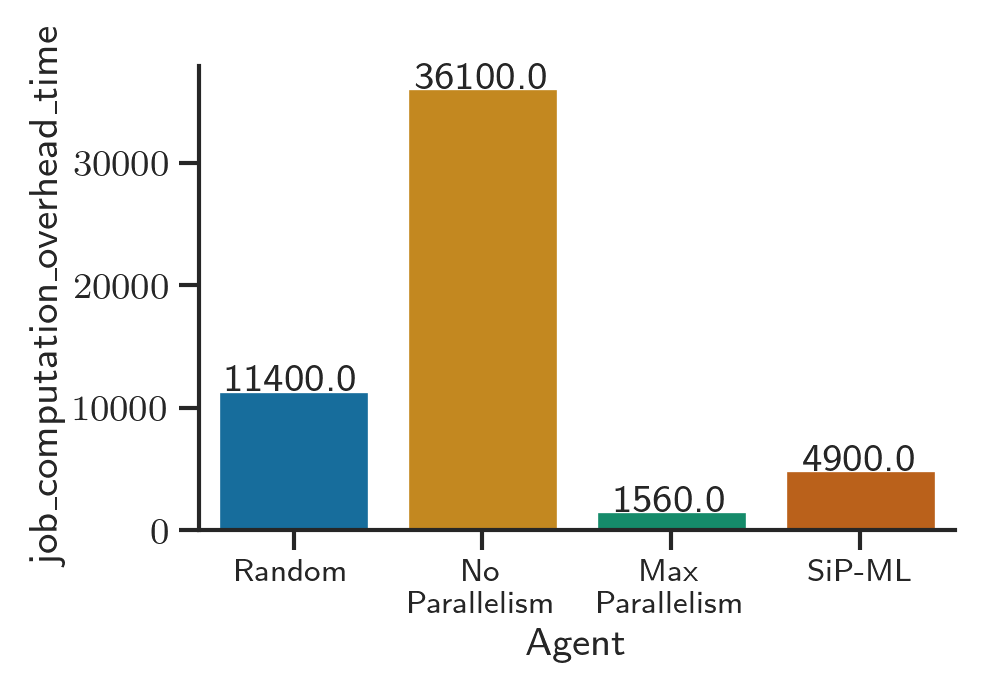

Plotting metric jobs_completed_total_operation_memory_cost -> min=3046234440.0 | max=3046234440.0 | mean=3046234440.0


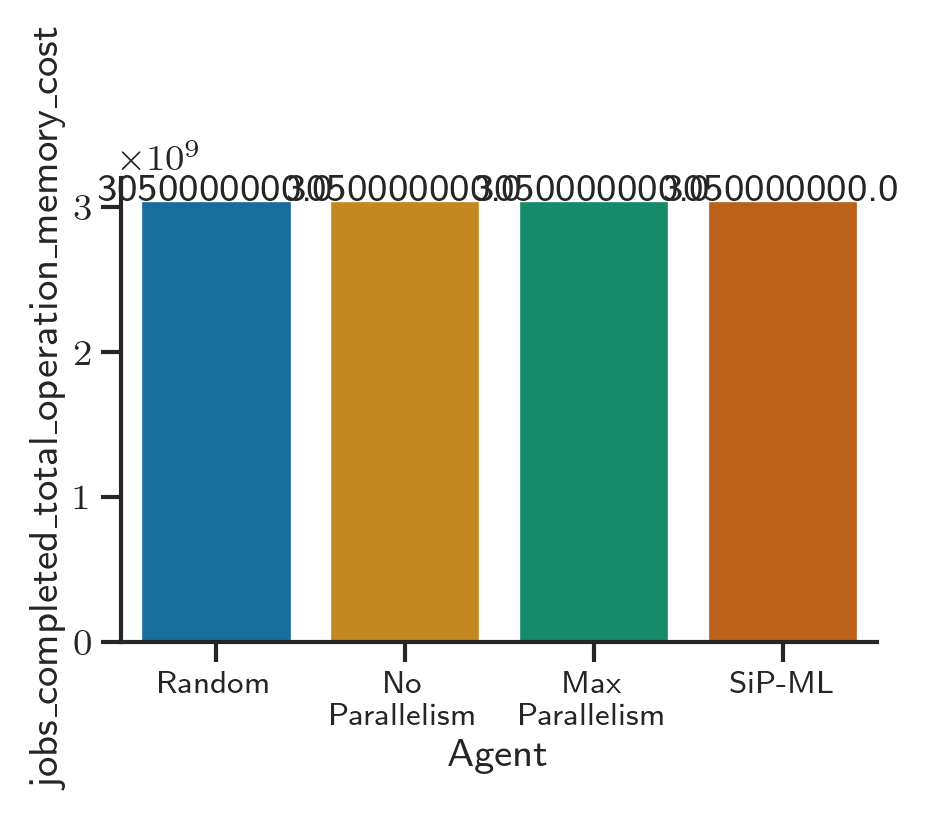

Plotting metric job_communication_overhead_time -> min=1708.970593396402 | max=36061.15 | mean=13537.810600370487


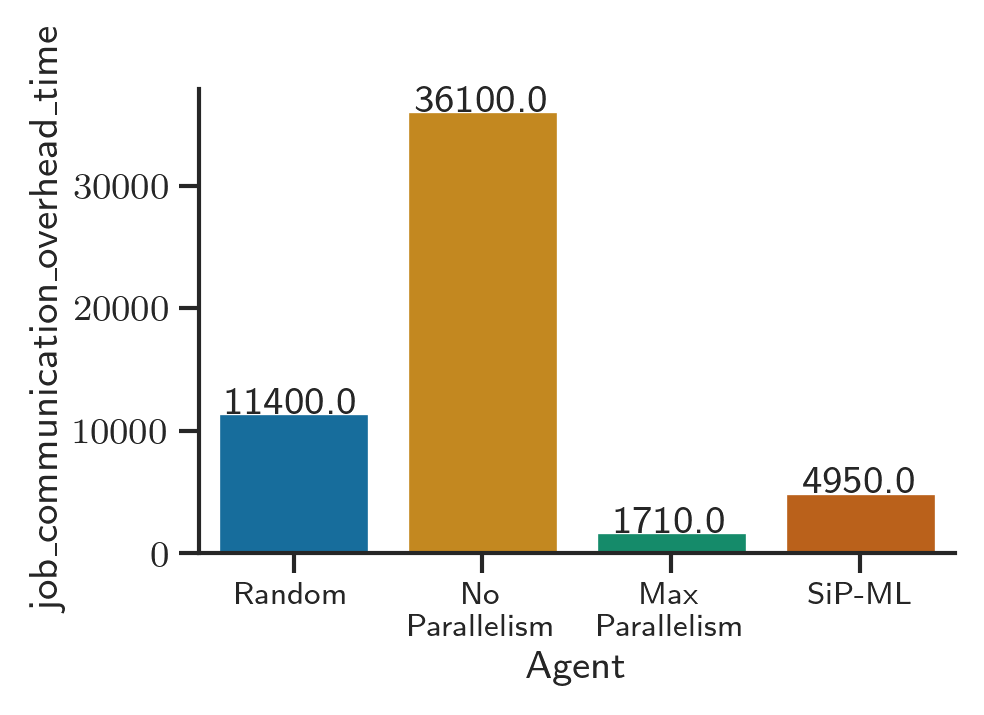

Plotting metric jobs_completed_total_dependency_size -> min=2910968136.0 | max=49228347148.0 | mean=18799127676.64707


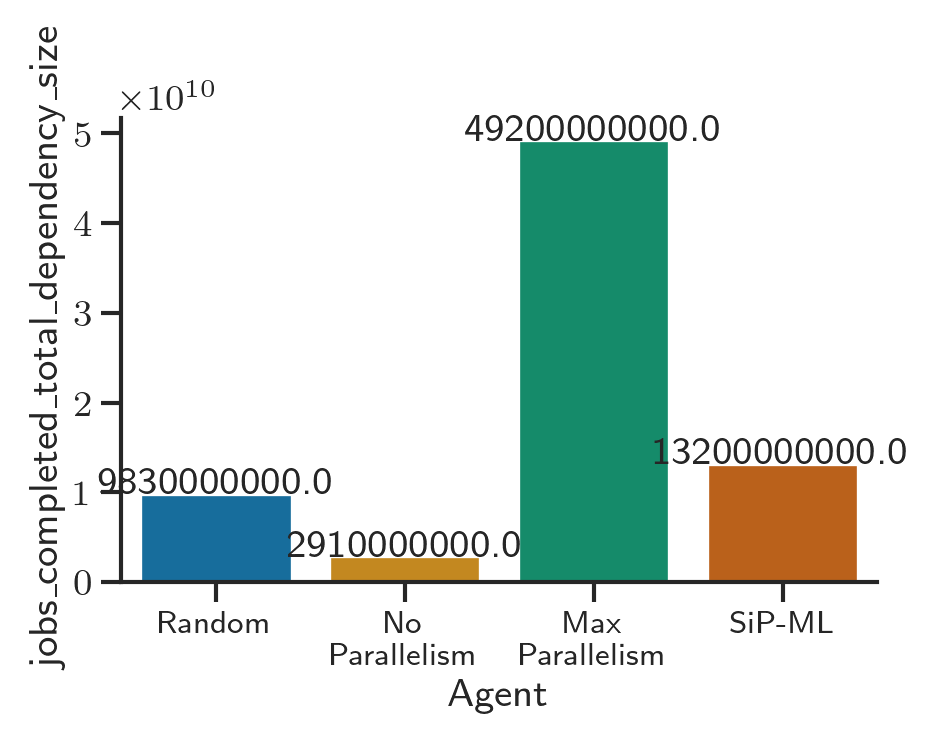

Plotting metric jobs_completed_num_nodes -> min=46.0 | max=1224.0 | mean=451.9852941176471


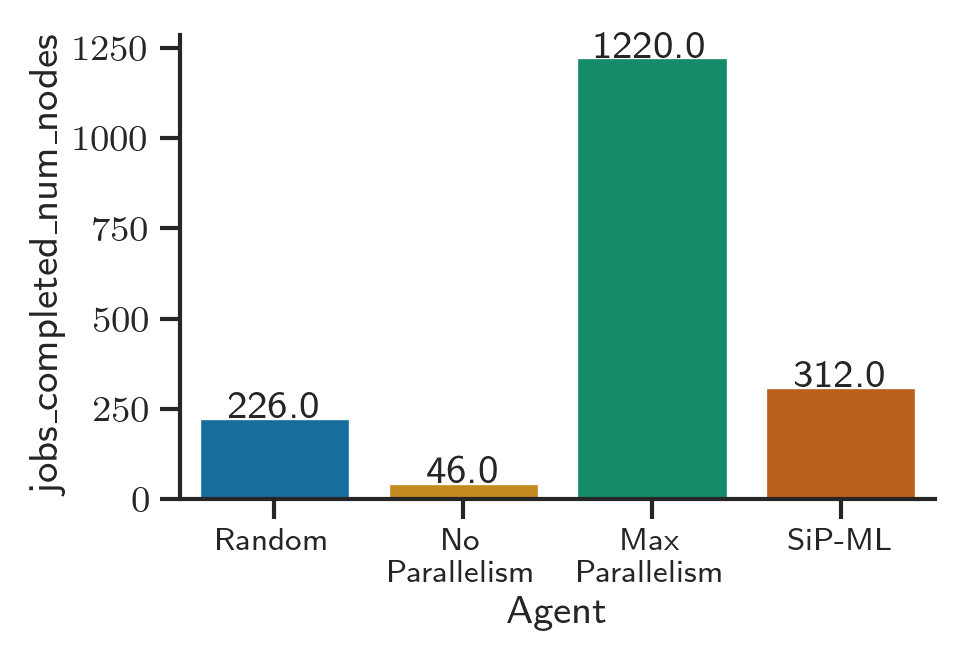

Plotting metric jobs_blocked_num_nodes -> min=46.0 | max=46.0 | mean=46.0


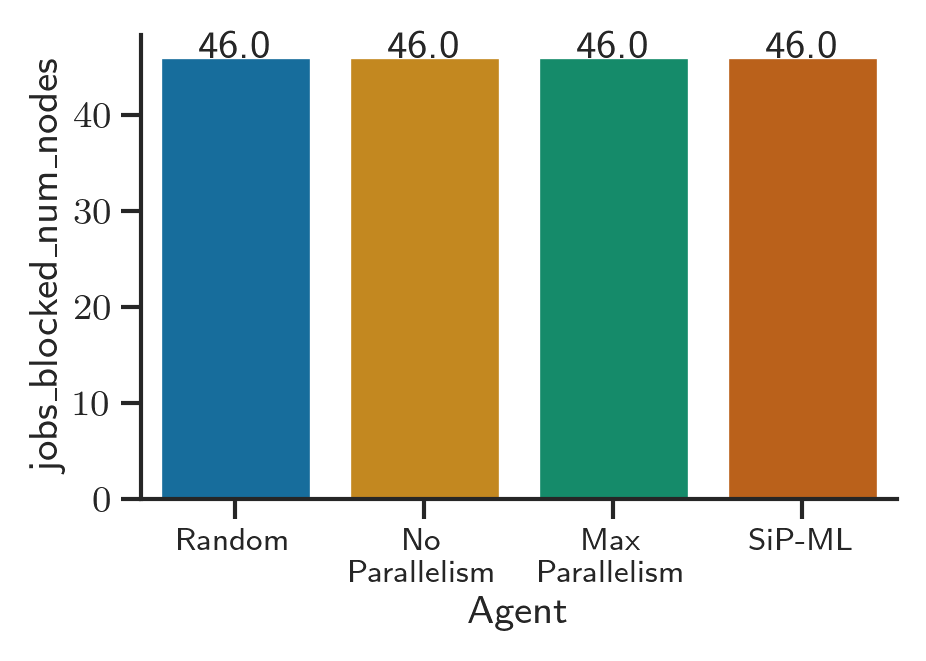

Plotting metric jobs_blocked_num_edges -> min=47.0 | max=47.0 | mean=47.0


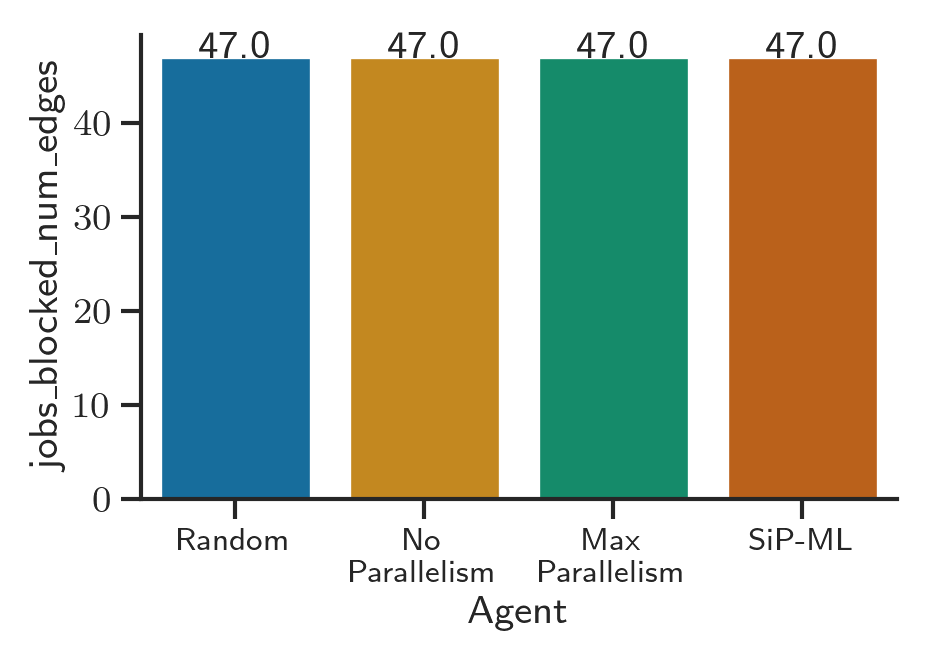

Plotting metric jobs_blocked_total_dependency_size -> min=2422161416.0 | max=2422161416.0 | mean=2422161416.0


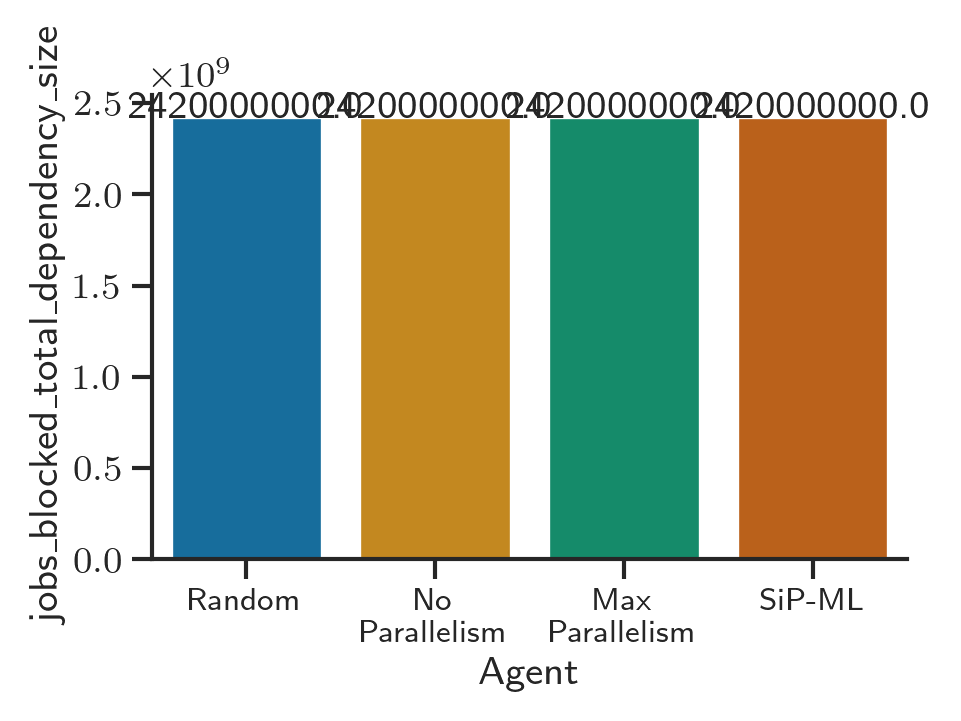

Plotting metric jobs_blocked_total_operation_memory_cost -> min=3046234440.0 | max=3046234440.0 | mean=3046234440.0


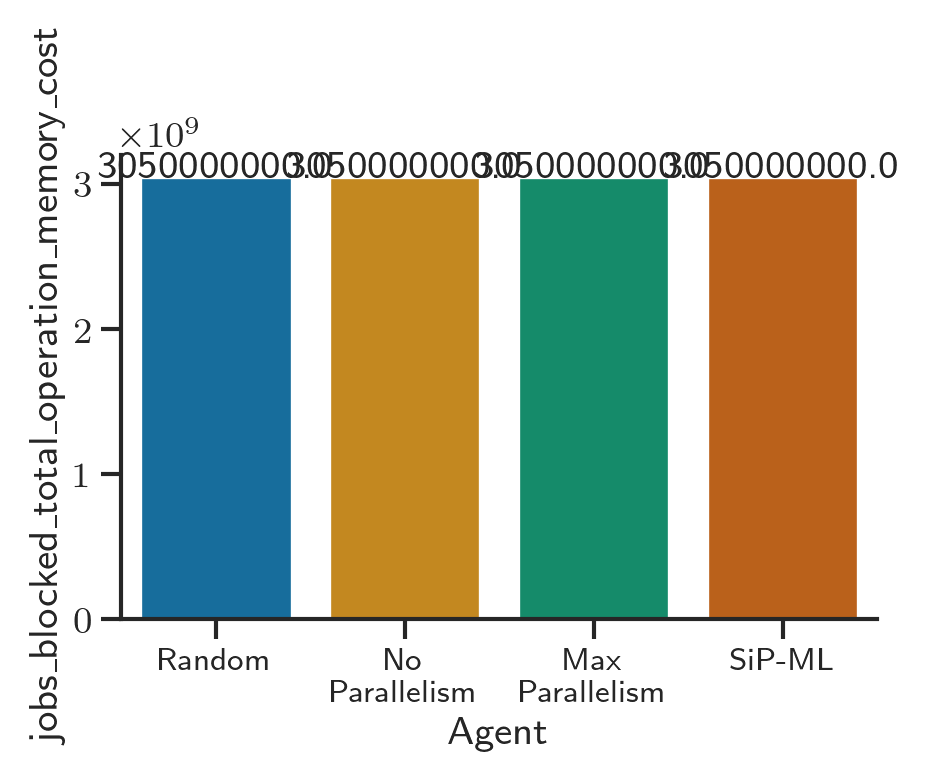



STEP METRICS
Plotting metric mean_cluster_throughput -> min=0.0 | max=30588344.69709025 | mean=10906844.483779684


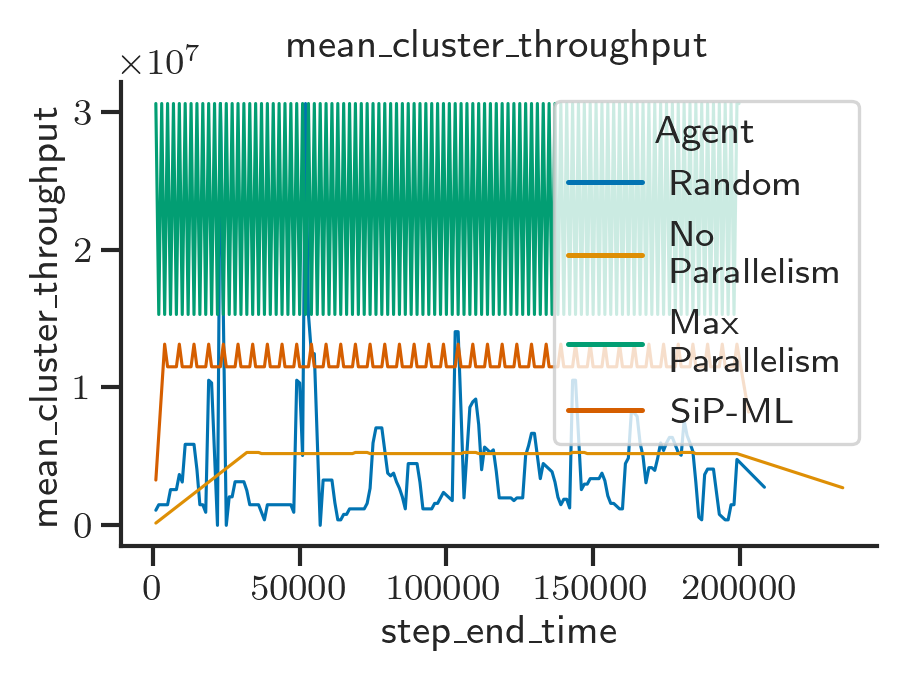

Plotting metric mean_num_mounted_workers -> min=0.0 | max=32.0 | mean=23.536875


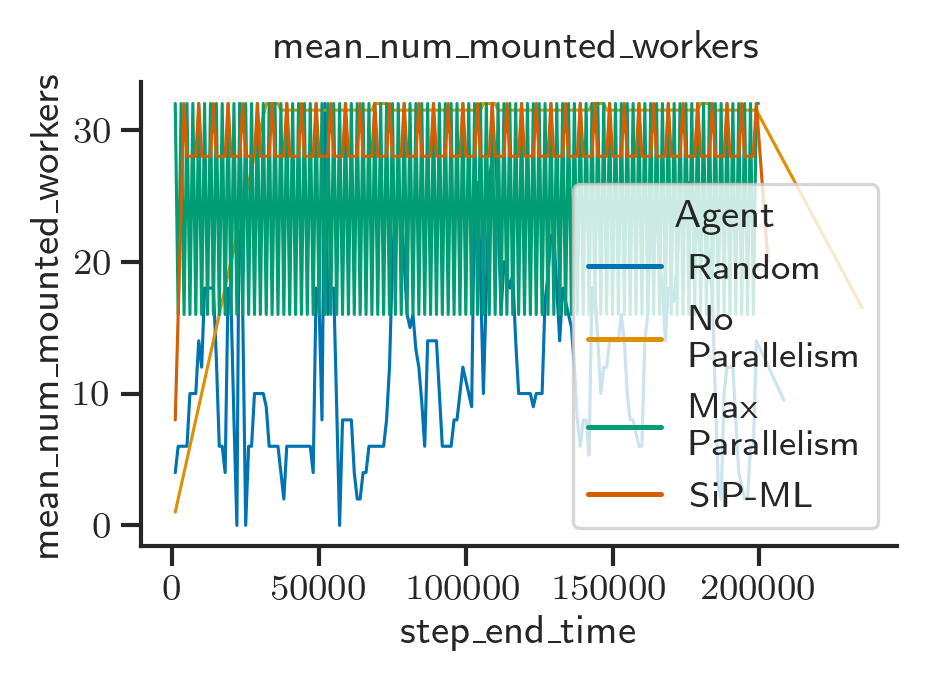

Plotting metric mean_comm_overhead_frac -> min=0.0 | max=1.0 | mean=0.910974018786522


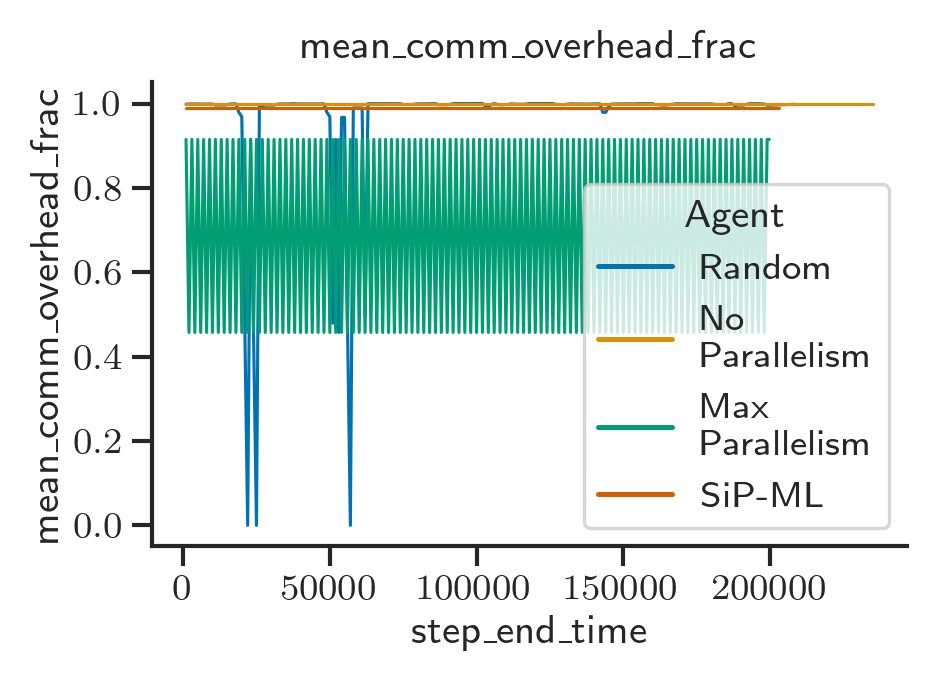

Plotting metric num_jobs_arrived -> min=0 | max=1 | mean=0.995


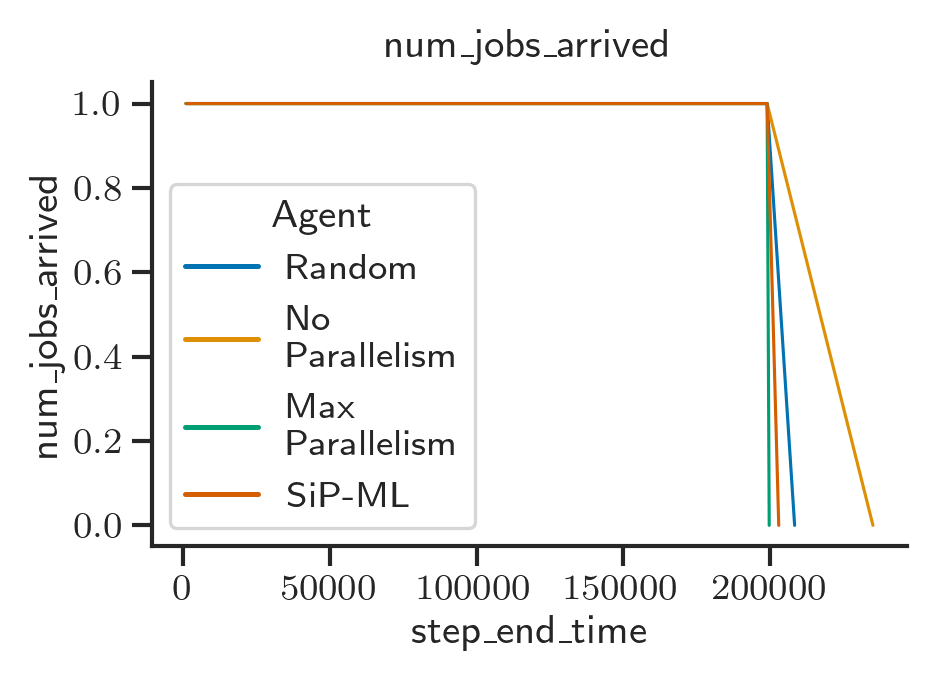

Plotting metric mean_mounted_worker_utilisation_frac -> min=0.6594092033265355 | max=0.9999999999999998 | mean=0.9147020512907033


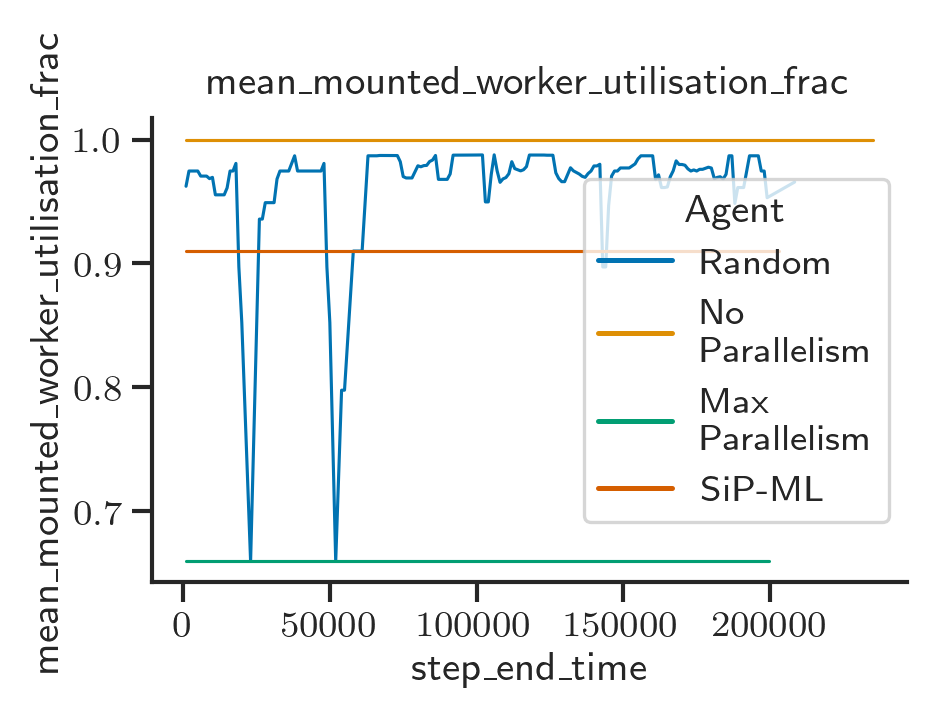

Plotting metric mean_compute_throughput -> min=0.0 | max=2703172.308148798 | mean=1744314.8423341382


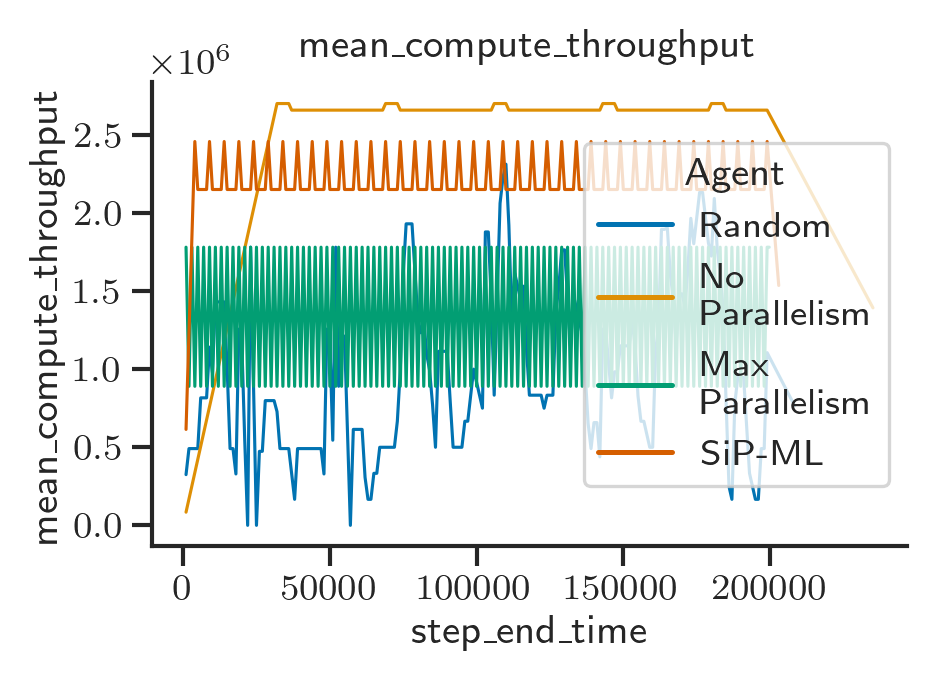

Plotting metric step_end_time -> min=1000.0 | max=235061.15 | mean=100557.61547748186


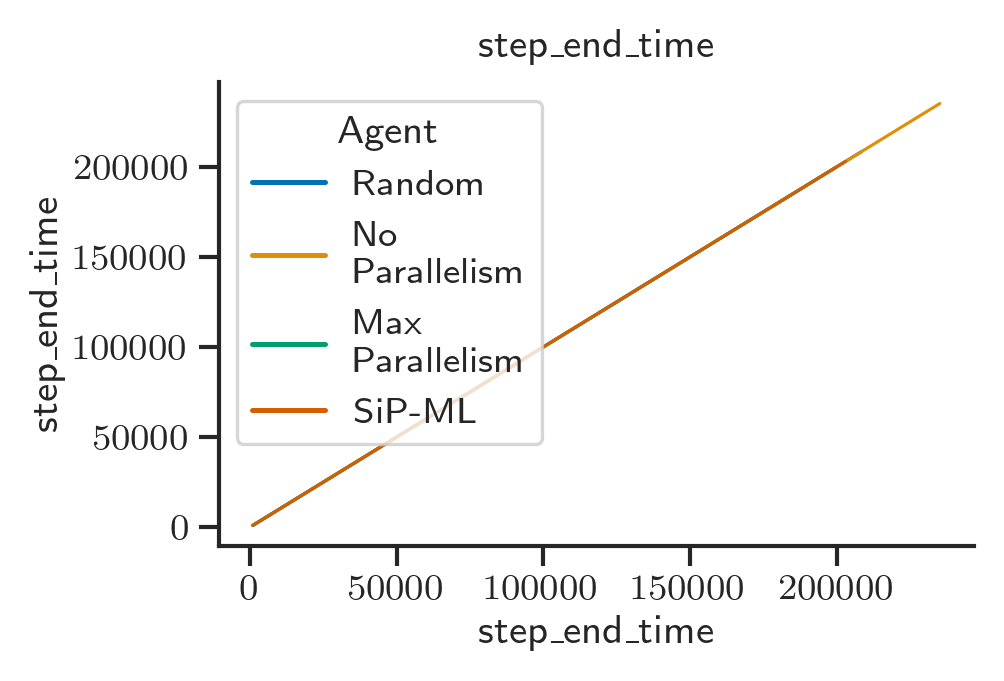

Plotting metric mean_comm_throughput -> min=0.0 | max=28805847.998919494 | mean=9162529.641445545


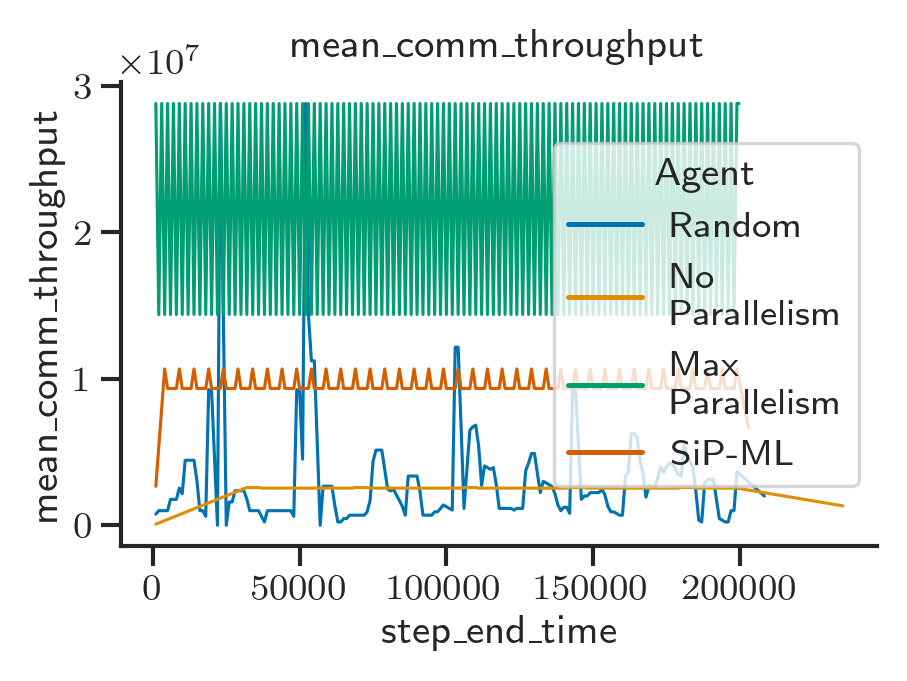

Plotting metric mean_cluster_worker_utilisation_frac -> min=0.03124999999999999 | max=0.9999999999999997 | mean=0.6983418350364226


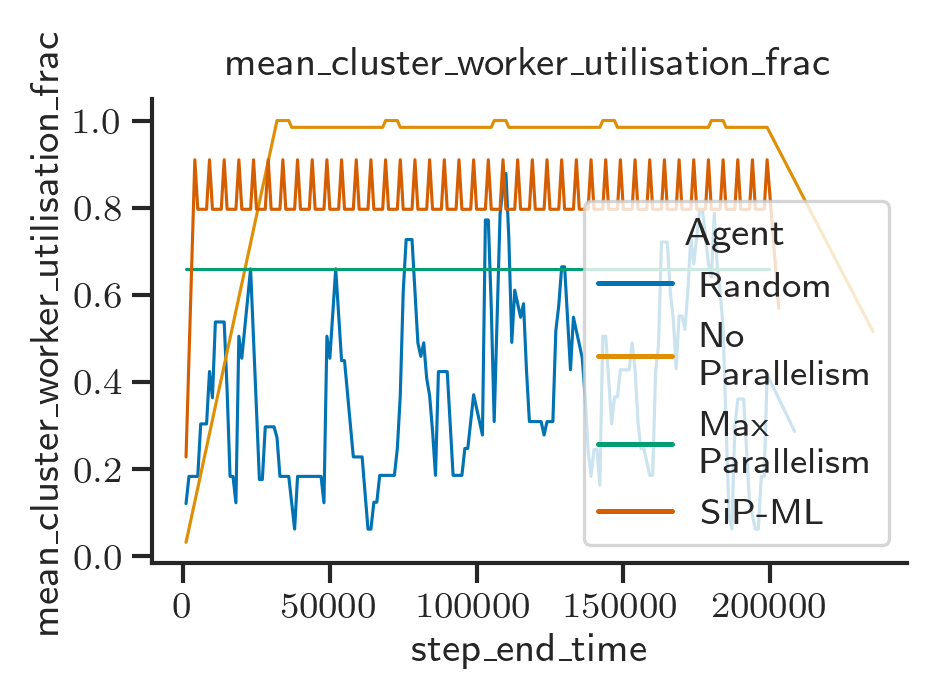

Plotting metric num_jobs_completed -> min=0 | max=32 | mean=0.62875


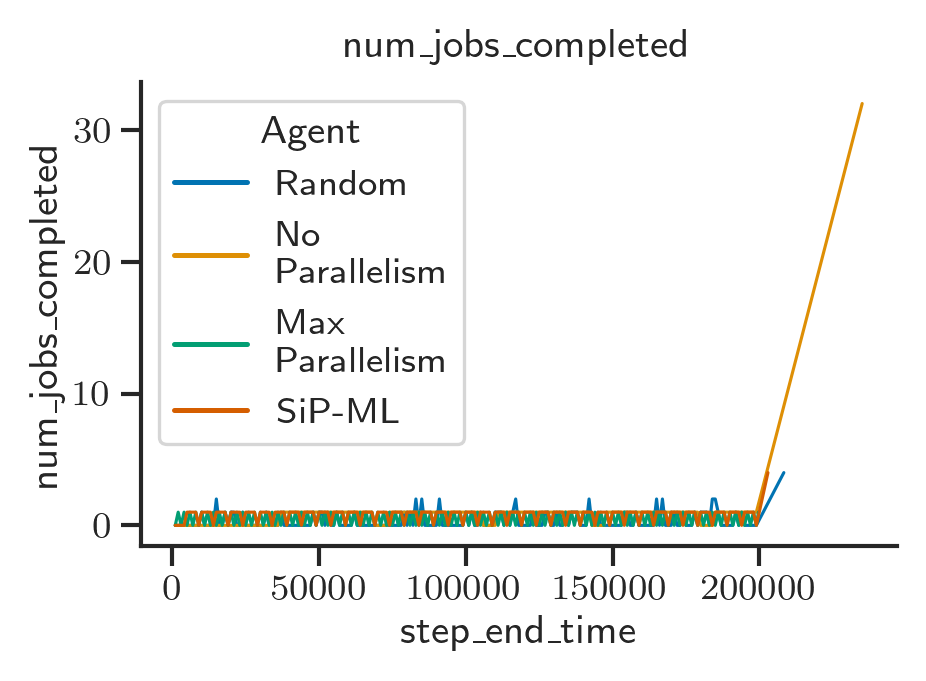

Plotting metric mean_compute_overhead_frac -> min=0.0 | max=1.0 | mean=0.930625


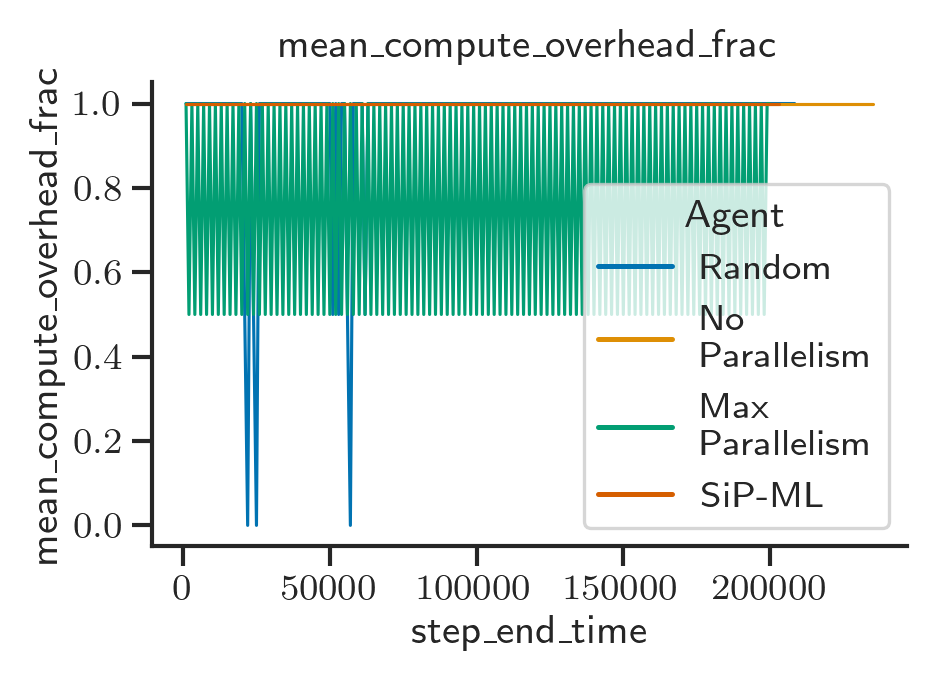

Plotting metric mean_num_mounted_channels -> min=0.0 | max=992.0 | mean=252.470625


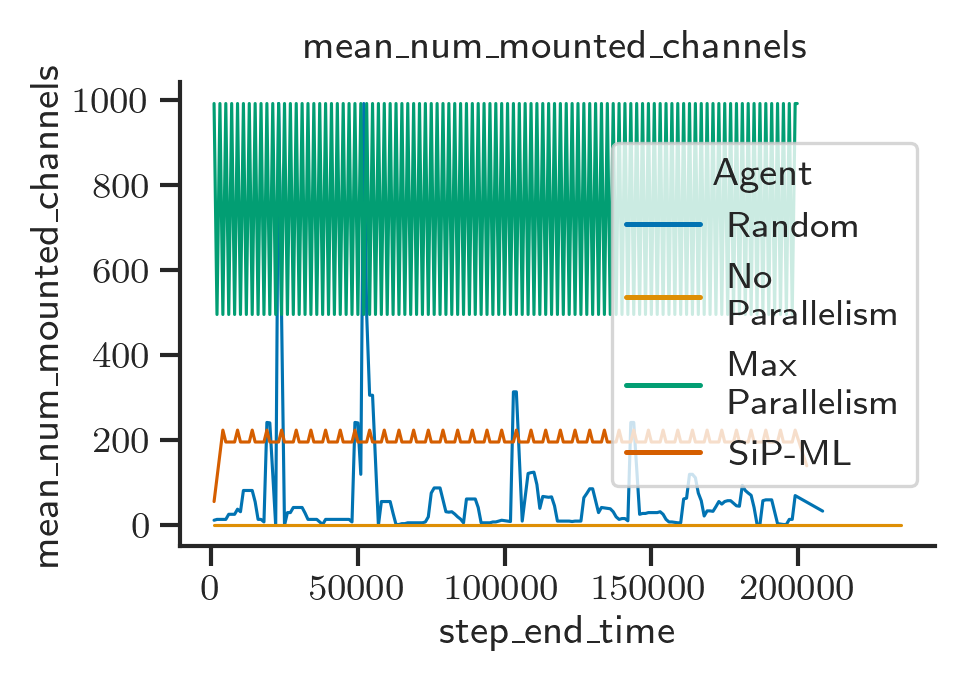

Plotting metric reward -> min=-1.0 | max=-0.023695453325759 | mean=-0.5107916683603231


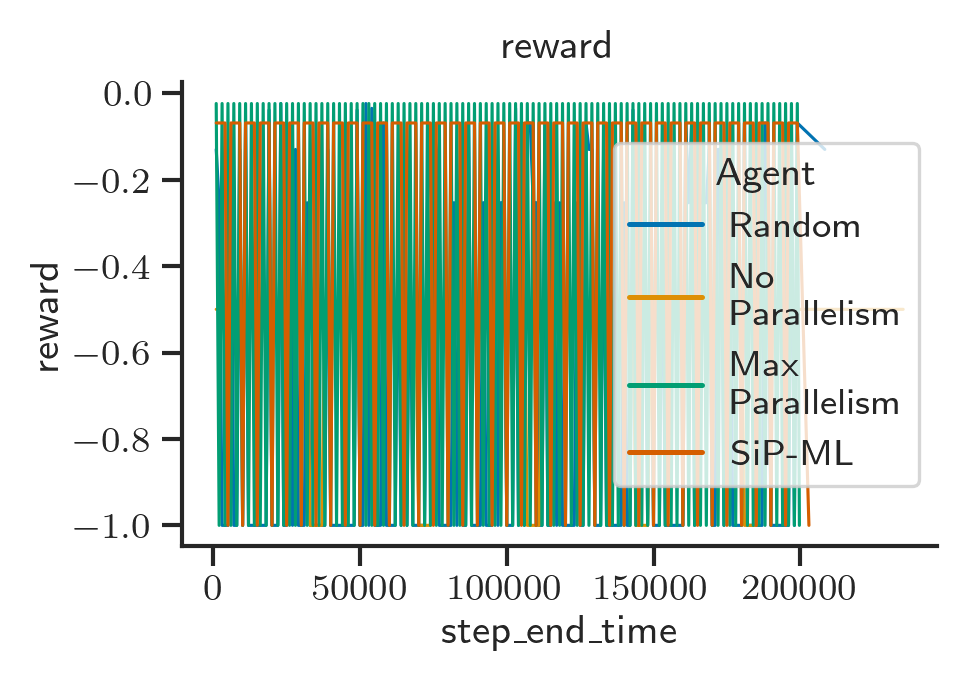

Plotting metric mean_num_jobs_running -> min=0.0 | max=32.0 | mean=9.295625


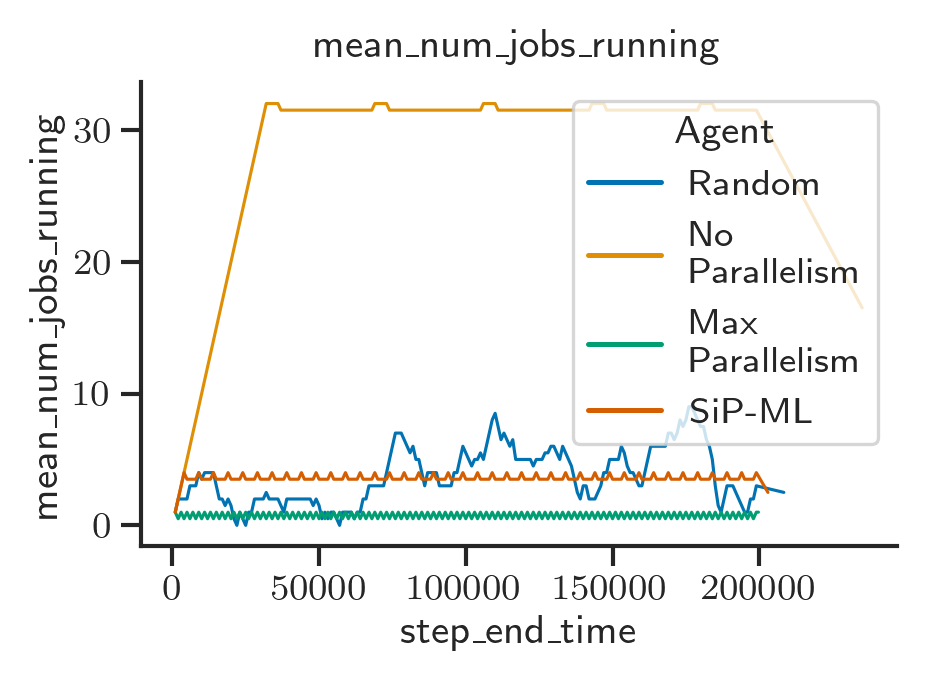

Plotting metric num_jobs_blocked -> min=0 | max=1 | mean=0.37125


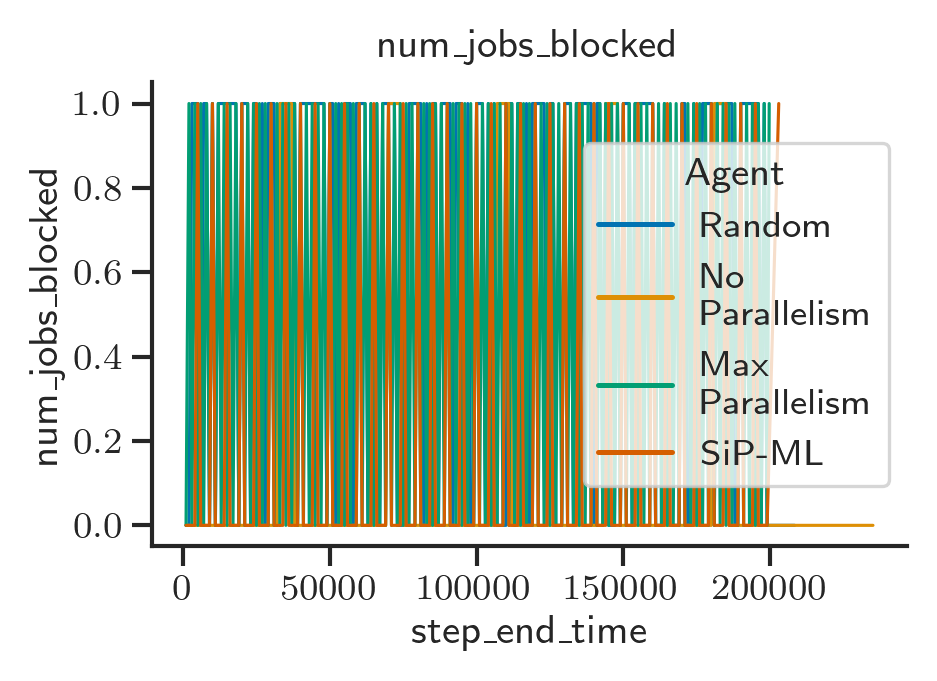

Plotting metric step_start_time -> min=0.0 | max=199000.0 | mean=99500.0


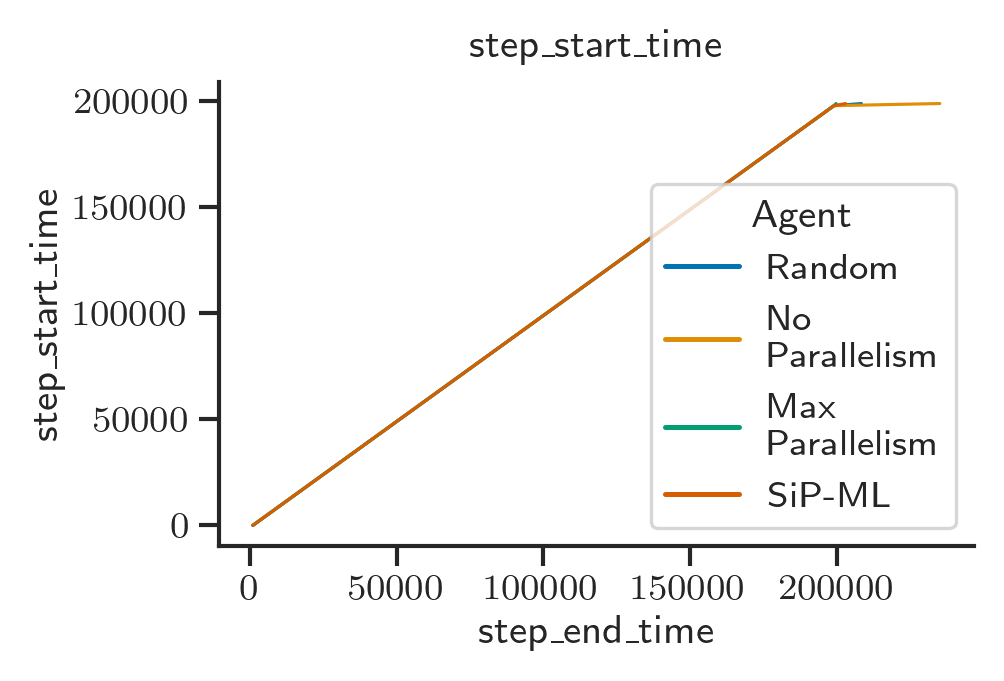

Plotting metric step_counter -> min=0 | max=373 | mean=153.47125


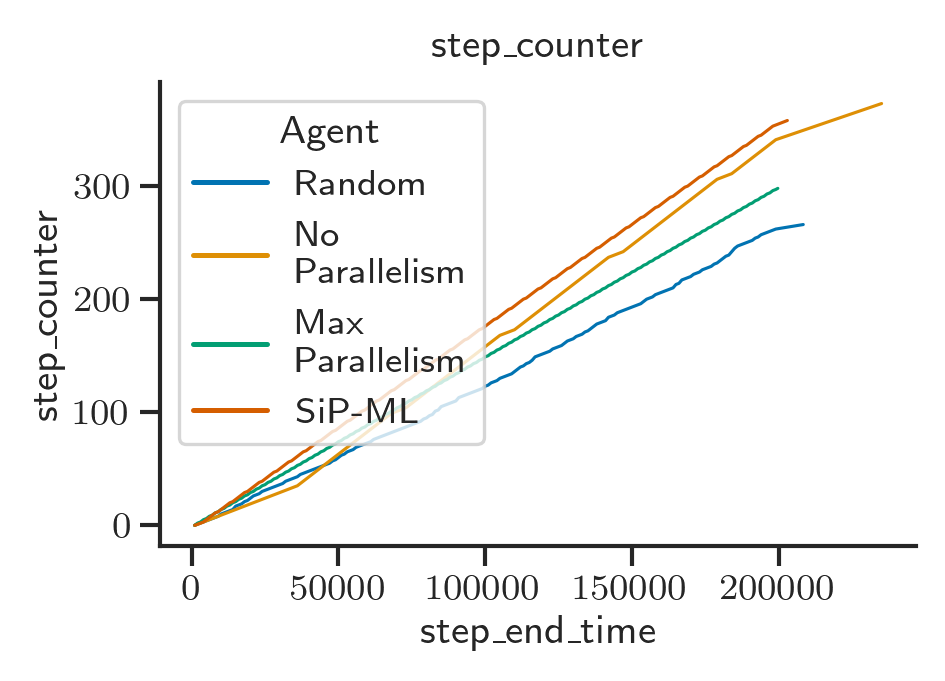

Plotting metric job_queue_length -> min=0 | max=1 | mean=0.995


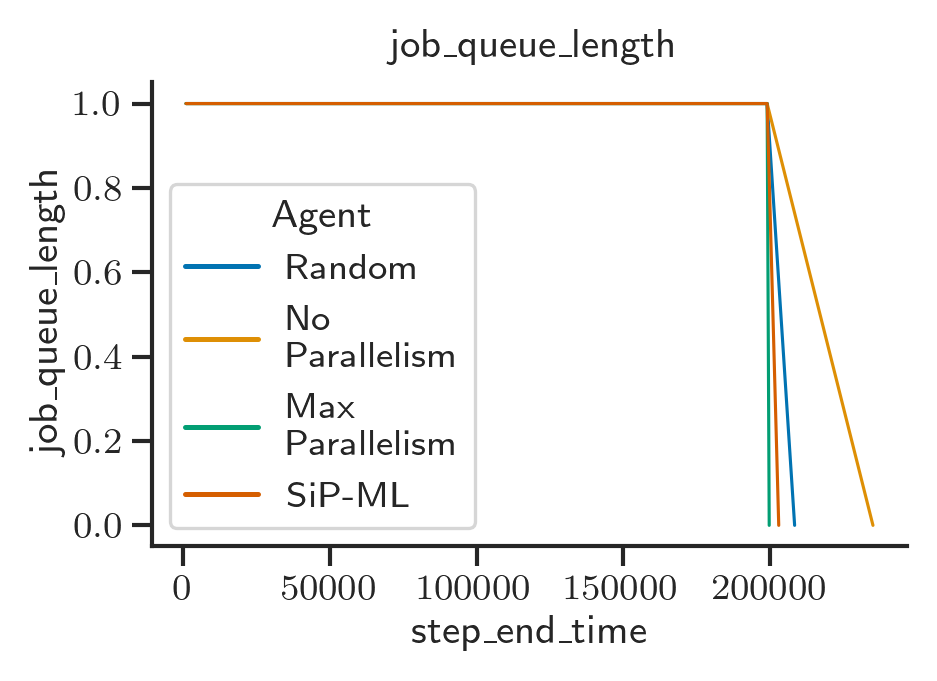

Plotting metric action -> min=0 | max=32 | mean=7.515


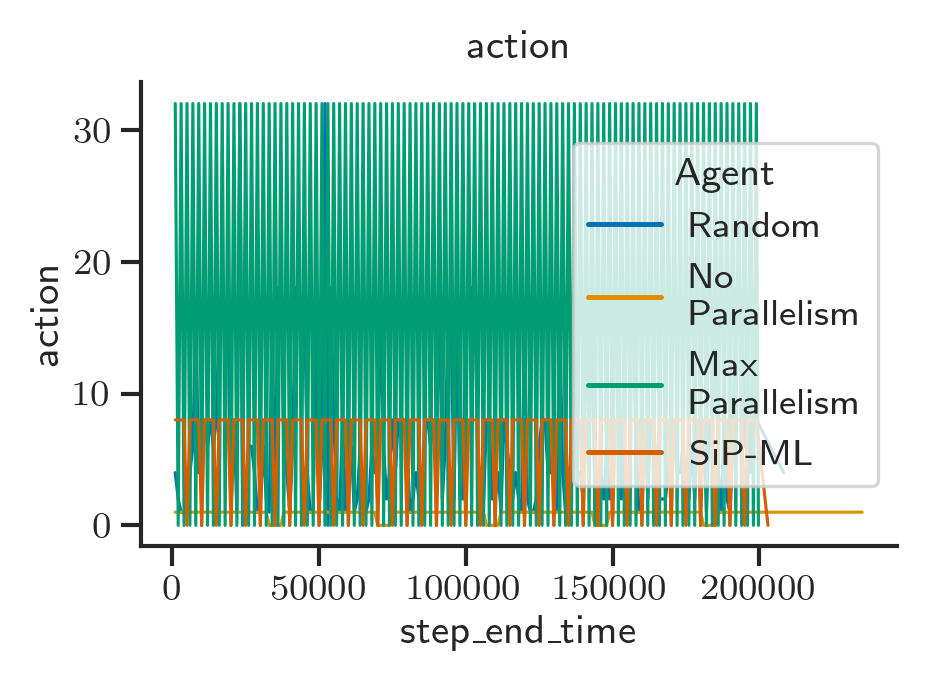

In [82]:
print(f'\n\nEPISODE METRICS')
for metric in episode_metrics:
    barplot(df=episode_stats_df, metric=metric, display_values=display_values)
if len(episode_completion_stats_df) > 0:
    for metric in episode_completion_metrics:
        barplot(df=episode_completion_stats_df, metric=metric)
if len(episode_blocked_stats_df) > 0:
    for metric in episode_blocked_metrics:
        barplot(df=episode_blocked_stats_df, metric=metric)
    
print(f'\n\nSTEP METRICS')
for metric in step_metrics:
    lineplot(df=step_stats_df, metric=metric)